In [2]:
from google.colab import files
uploaded = files.upload()

Saving spotify_df_merged.csv to spotify_df_merged.csv


In [33]:
# Converting into a data frame
import pandas as pd

df = pd.read_csv("spotify_df_merged.csv")

# Checking data structure
print(df.head())

                       id                   name                  album  \
0  7lmeHLHBe4nmXzuXc0HDjk                Testify                Testify   
1  1wsRitfRRtWyEapl0q22o8        Guerrilla Radio        Guerrilla Radio   
2  1hR0fIFK2qRG3f3RF70pb7       Calm Like a Bomb       Calm Like a Bomb   
3  2lbASgTSoDO7MTuLAXlTW0              Mic Check              Mic Check   
4  1MQTmpYOZ6fcMQc56Hdo7T  Sleep Now In the Fire  Sleep Now In the Fire   

                 album_id                       artists  \
0  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
1  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
2  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
3  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
4  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   

                   artist_ids  track_number  disc_number  explicit  \
0  ['2d0hyoQ5ynDBnkvAbJKORj']             1            1     False   
1  ['2d0hyoQ5ynDBnkvAbJKORj']             2           

In [34]:
print(df.columns)

Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids',
       'track_number', 'disc_number', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'year', 'release_date', 'release_date_parsed',
       'duration_min', 'total_grammy_awards', 'total_grammy_nominations'],
      dtype='object')


In [42]:
print(df["liveness"])

0          0.3560
1          0.1550
2          0.1220
3          0.1210
4          0.0789
            ...  
1204023    0.3370
1204024    0.0749
1204025    0.0664
1204026    0.1170
1204027    0.2790
Name: liveness, Length: 1204028, dtype: float64


In [43]:
# Engineer date features

# Convert 'release_date' to datetime
df['release_date_parsed'] = pd.to_datetime(df['release_date_parsed'], errors='coerce')

# Extract features from 'release_date'
df['release_year'] = df['release_date_parsed'].dt.year
df['release_month'] = df['release_date_parsed'].dt.month
df['release_day'] = df['release_date_parsed'].dt.day

# Adding release day of week feature (Monday = 0 , Sunday = 6)
df['release_weekday'] = df['release_date_parsed'].dt.weekday

# Drop unnecessary columns
df = df.drop(columns=['release_date', 'year', 'release_date_parsed'])

In [44]:
# Transform explicit feature into binary 0/1
df['explicit'] = df['explicit'].astype(int)

# Transform mode feature into binary 0/1
df['mode'] = df['mode'].astype(int)

In [45]:
# Creating target variable (popularity)
df["popularity"] = df["total_grammy_awards"] + df["total_grammy_nominations"]

# Removing original columns
df.drop(columns=["total_grammy_awards", "total_grammy_nominations"], inplace=True)

In [46]:
# Remove highly correlated features

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=["popularity"])
y = df["popularity"]

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Remove identifier columns
X = X.drop(columns=['id', 'name', 'album', 'album_id', 'artists', 'artist_ids'])

# Compute correlation matrix
corr_matrix = X.corr().abs()

# Identify highly correlated features (above 0.85 threshold)
threshold = 0.85
high_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Drop correlated features
X_filtered = X.drop(columns=high_corr_features)
print("Remaining features after correlation filter:", X_filtered.columns)

Non-numeric columns: Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids'], dtype='object')
Remaining features after correlation filter: Index(['track_number', 'disc_number', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'release_year', 'release_month', 'release_day',
       'release_weekday'],
      dtype='object')


In [47]:
# Removing missing values

# Drop rows with NaNs in both X and y

X_filtered = X_filtered.dropna(subset=['release_year', 'release_month', 'release_day', 'release_weekday'])
X_filtered, y = X_filtered.align(y, join="inner", axis=0)

print(X_filtered.isnull().sum())

track_number        0
disc_number         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
release_year        0
release_month       0
release_day         0
release_weekday     0
dtype: int64


In [48]:
# Lasso Regression for Feature Selection

from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Apply cross validation to tune alpha
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 10), cv=5)
lasso_cv.fit(X_scaled, y)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print("Optimal Alpha from LassoCV:", best_alpha)

# Fit Lasso using the optimal alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_scaled, y)

# Get selected features (non-zero coefficients)
selected_features = X_filtered.columns[lasso.coef_ != 0]
X_lasso_selected = X_filtered[selected_features]

print("Selected features after Lasso:", selected_features)

Optimal Alpha from LassoCV: 0.0001
Selected features after Lasso: Index(['track_number', 'disc_number', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'release_year', 'release_month', 'release_day',
       'release_weekday'],
      dtype='object')


In [49]:
# Use RFE to Refine Feature Selection (choosing an optimal number of features)

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Initialize RFECV with cross-validation
estimator = LinearRegression()
rfecv = RFECV(estimator, cv=5)
X_rfecv_selected = rfecv.fit_transform(X_lasso_selected, y)

# Get the best number of features
optimal_features = sum(rfecv.support_)
print("Optimal number of features:", optimal_features)

# Get the selected feature names
selected_features_rfecv = X_lasso_selected.columns[rfecv.support_]
print("Selected features after RFECV:", selected_features_rfecv)

Optimal number of features: 17
Selected features after RFECV: Index(['track_number', 'disc_number', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'time_signature', 'release_year',
       'release_month', 'release_day', 'release_weekday'],
      dtype='object')


In [50]:
import pandas as pd

# Convert the transformed NumPy array back to a DataFrame with the selected feature names
X_rfecv_selected_df = pd.DataFrame(X_rfecv_selected, columns=selected_features_rfecv)

# This is the final refined feature set to be used for further feature engineering
print("Final shape of X_rfecv_selected_df:", X_rfecv_selected_df.shape)

Final shape of X_rfecv_selected_df: (1204018, 17)


In [51]:
# Check how many polynomial features are needed

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_rfecv_selected_df)

# Fit LassoCV to determine if new features are useful
lasso_cv = LassoCV(cv=5).fit(X_poly, y)

# Count selected polynomial features
num_selected = sum(lasso_cv.coef_ != 0)

print(f"Number of useful polynomial features: {num_selected}")

Number of useful polynomial features: 12


In [52]:
# Identifying useful polynomial features

import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_rfecv_selected_df)

# Fit LassoCV to determine if new features are useful
lasso_cv = LassoCV(cv=5).fit(X_poly, y)

# Get the original and polynomial feature names
feature_names = poly.get_feature_names_out(X_rfecv_selected_df.columns)

# Identify selected polynomial features
selected_poly_features = np.array(feature_names)[lasso_cv.coef_ != 0]

print(f"Selected Polynomial Features ({len(selected_poly_features)}):")
print(selected_poly_features)

Selected Polynomial Features (12):
['track_number release_year' 'disc_number release_year'
 'energy release_year' 'loudness release_year' 'mode release_year'
 'acousticness release_year' 'instrumentalness release_year'
 'liveness release_year' 'release_year^2' 'release_year release_month'
 'release_year release_day' 'release_year release_weekday']


In [53]:
# Adding polynomial features in

# Create a DataFrame for polynomial features
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_rfecv_selected_df.columns), index=X_rfecv_selected_df.index)

# Keep only the selected polynomial features
X_selected_poly = X_poly_df[selected_poly_features]

# Concatenate with original features
X_final = pd.concat([X_rfecv_selected_df, X_selected_poly], axis=1)

print("Final feature set shape:", X_final.shape)

Final feature set shape: (1204018, 29)


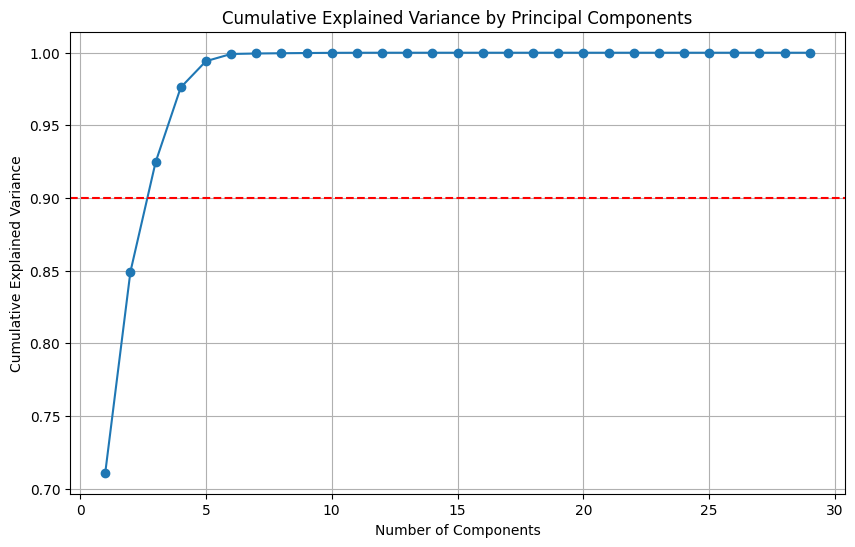

In [54]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA()
pca.fit(X_final)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.90, color='r', linestyle='--')  # Example threshold for 90%
plt.show()

In [59]:
from sklearn.decomposition import PCA
import pandas as pd

# Fit PCA to feature set
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_final)

# Create a DataFrame for the PCA loadings
loadings = pd.DataFrame(pca.components_, columns=X_final.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# Display the loadings
print("PCA Loadings:\n", loadings)

# Choose threshold to select features for each PC
threshold = 0.1
selected_features = []

for i in range(loadings.shape[0]):
    pc_loadings = loadings.iloc[i]
    significant_features = pc_loadings[abs(pc_loadings) > threshold].index.tolist()
    selected_features.extend(significant_features)

# Remove duplicates
selected_features = list(set(selected_features))

print("Selected features based on PCA loadings:", selected_features)

PCA Loadings:
      track_number   disc_number      explicit  danceability        energy  \
PC1     -0.000006 -2.705764e-07  9.970009e-07  4.081718e-07  1.266395e-06   
PC2     -0.000005 -6.502316e-09  5.453692e-07  5.123339e-07  1.141355e-06   
PC3     -0.000197 -1.673159e-06  2.084024e-06  4.562197e-06  1.573060e-05   
PC4      0.000457 -1.254133e-06  1.102454e-06  2.209086e-06  6.639850e-06   
PC5     -0.000006  1.053285e-06  1.390782e-06  5.763729e-08  5.656067e-08   
PC6      0.000001 -6.652384e-07  2.235112e-06  6.868475e-07  2.617854e-07   

     loudness          mode   speechiness  acousticness  instrumentalness  \
PC1  0.000036 -6.877489e-07  1.858161e-07 -1.709908e-06     -1.596610e-07   
PC2  0.000032  4.533322e-08  1.054494e-07 -1.203413e-06     -8.619820e-07   
PC3  0.000454  3.279468e-07  2.123091e-07 -1.690071e-05     -9.849580e-06   
PC4  0.000197  6.444553e-07  6.883033e-07 -6.270232e-06     -4.928886e-06   
PC5  0.000002 -1.499246e-07  1.591638e-07 -1.017820e-07     